# 03 — Classification Modelling
Mục tiêu: train mô hình phân lớp AQI (6 lớp), split theo thời gian, đánh giá bằng accuracy + macro-F1, confusion matrix, và lưu metrics/prediction sample.

In [1]:
DATASET_PATH = 'data/processed/dataset_for_clf.parquet'
CUTOFF = '2017-01-01'
METRICS_PATH = 'data/processed/metrics.json'
PRED_SAMPLE_PATH = 'data/processed/predictions_sample.csv'


In [2]:
# Parameters
DATASET_PATH = "data/processed/dataset_for_clf.parquet"
CUTOFF = "2017-01-01"
METRICS_PATH = "data/processed/metrics.json"
PRED_SAMPLE_PATH = "data/processed/predictions_sample.csv"


In [3]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.classification_library import time_split, train_classifier, AQI_CLASSES

PROJECT_ROOT = Path('..').resolve()
dataset_path = (PROJECT_ROOT / DATASET_PATH).resolve()
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
metrics_path.parent.mkdir(parents=True, exist_ok=True)
pred_path.parent.mkdir(parents=True, exist_ok=True)


In [4]:
df = pd.read_parquet(dataset_path)
print('shape:', df.shape)
df[['datetime','station','aqi_class']].head()

shape: (412935, 55)


,datetime,station,aqi_class
0,2013-03-01 17:00:00,Aotizhongxin,Good
1,2013-03-01 18:00:00,Aotizhongxin,Good
2,2013-03-01 19:00:00,Aotizhongxin,Good
3,2013-03-01 20:00:00,Aotizhongxin,Good
4,2013-03-01 21:00:00,Aotizhongxin,Good


In [5]:
train_df, test_df = time_split(df, cutoff=CUTOFF)
print('train:', train_df.shape, '| test:', test_df.shape)
print('test date range:', test_df['datetime'].min(), '->', test_df['datetime'].max())

train: (396264, 55) | test: (16671, 55)
test date range: 2017-01-01 00:00:00 -> 2017-02-28 23:00:00


In [6]:
out = train_classifier(train_df, test_df, target_col='aqi_class')
metrics = out['metrics']
pred_df = out['pred_df']

print('Accuracy:', metrics['accuracy'])
print('F1-macro:', metrics['f1_macro'])
pred_df.head()

D:\Anaconda3\envs\beijing_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Anaconda3\envs\beijing_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.6022434167116549
F1-macro: 0.47153196677178205


D:\Anaconda3\envs\beijing_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,datetime,station,y_true,y_pred
0,2017-01-01 00:00:00,Aotizhongxin,Hazardous,Hazardous
1,2017-01-01 01:00:00,Aotizhongxin,Hazardous,Hazardous
2,2017-01-01 02:00:00,Aotizhongxin,Hazardous,Very_Unhealthy
3,2017-01-01 03:00:00,Aotizhongxin,Hazardous,Very_Unhealthy
4,2017-01-01 04:00:00,Aotizhongxin,Hazardous,Hazardous


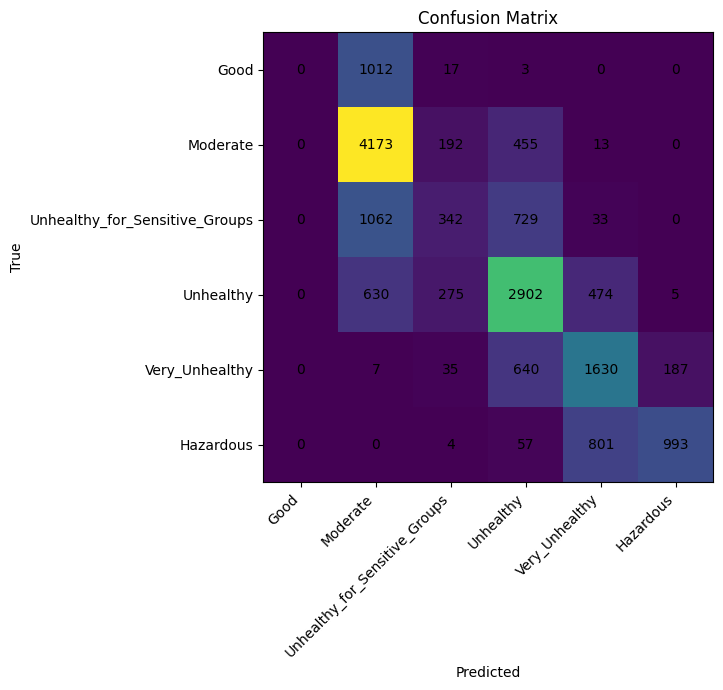

In [7]:
# Confusion matrix plot
cm = np.array(metrics['confusion_matrix'])
labels = metrics['labels']

plt.figure(figsize=(9, 7))
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(int(cm[i, j])), ha='center', va='center')

plt.tight_layout()
plt.show()

In [8]:
# Lưu metrics + sample prediction
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
print('Saved:', metrics_path)
print('Saved:', pred_path)

Saved: D:\KhaiPhaDuLieu\BT\New folder (2)\data\processed\metrics.json
Saved: D:\KhaiPhaDuLieu\BT\New folder (2)\data\processed\predictions_sample.csv


In [9]:
# In classification report (rút gọn)
report = metrics['report']
summary = {k: report[k] for k in ['accuracy', 'macro avg', 'weighted avg'] if k in report}
summary

{'accuracy': 0.6022434167116549,
 'macro avg': {'precision': 0.4997076103615102,
  'recall': 0.4809987777037216,
  'f1-score': 0.47153196677178205,
  'support': 16671.0},
 'weighted avg': {'precision': 0.5590363071223252,
  'recall': 0.6022434167116549,
  'f1-score': 0.5626572545230011,
  'support': 16671.0}}